In [16]:
#environment settings
#!pip install tensorflow keras

In [17]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import tensorflow as tf
import tensorflowjs as tfjs

In [18]:
#common variables
sc = MinMaxScaler(feature_range=(0,1))

In [19]:
#common functions
def load_dataframe(**kwargs):
    stock_name = kwargs["stock_name"]
    start_year = kwargs["start_year"]
    end_year = kwargs["end_year"]
    df = yf.download(stock_name, start=f'{start_year}-01-01', end=f'{end_year}-01-01')
    #df = pd.read_csv(f'./stocks/{name}.csv') # Default load local csv file
    return df
    
def get_X_train(**kwargs):
    df = kwargs['df']
    start_index = kwargs['start_index']
    end_index = kwargs['end_index']
    day_before = kwargs["day_before"]
    X_train = df.iloc[start_index:end_index, 0:1].values
    X_train = sc.fit_transform(X_train)
    X_train = [X_train[i-day_before:i, 0] for i in range(day_before, len(X_train))]
    X_train = np.array(X_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    return X_train

def get_y_train(**kwargs):
    df = kwargs['df']
    start_index = kwargs['start_index']
    end_index = kwargs['end_index']
    day_before = kwargs['day_before']
    y_train = df.iloc[start_index:end_index, 1:2].values
    y_train = sc.fit_transform(y_train)[0+day_before:end_index]
    return y_train

def save_model(**kwargs):
    model = kwargs["model"]
    dir = kwargs["dir"]
    tfjs.converters.save_keras_model(model, dir)    
    
def get_X_test():
    return 1
def get_y_test():
    return 1

In [20]:
#init
stock_name = "AMD"
start_year = 2002
end_year = 2022
df = load_dataframe(stock_name=stock_name, start_year=start_year, end_year=end_year)
print("Number of rows and columns:", df.shape)
#df.head(5)
start_index = 0
end_index = round(len(df)*0.8)
day_before = 60

[*********************100%%**********************]  1 of 1 completed
Number of rows and columns: (5036, 6)


In [21]:
X_train = get_X_train(df=df, start_index=start_index, end_index=end_index, day_before=day_before)
y_train = get_y_train(df=df, start_index=start_index, end_index=end_index, day_before=day_before)
print(X_train.shape)
print(y_train.shape)

(3969, 60, 1)
(3969, 1)


In [22]:
(X_train.shape[0], X_train.shape[1], 1)

(3969, 60, 1)

In [23]:
#splitin train set & train set
training_set = df.iloc[:800, 1:2].values
test_set = df.iloc[800:, 1:2].values

sc = MinMaxScaler(feature_range = (0, 1))

In [24]:
# Feature Scaling
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 800):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(740, 60, 1)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (740, 60, 1)
y_train shape: (740,)


In [25]:
#numpy version require 1.19.5 
#!pip install numpy==1.19.5
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
24/24 [==============================] - 7s 92ms/step - loss: 0.0372
Epoch 2/100
24/24 [==============================] - 2s 94ms/step - loss: 0.0111
Epoch 3/100
24/24 [==============================] - 2s 89ms/step - loss: 0.0094
Epoch 4/100
24/24 [==============================] - 2s 89ms/step - loss: 0.0091
Epoch 5/100
24/24 [==============================] - 2s 90ms/step - loss: 0.0077
Epoch 6/100
24/24 [==============================] - 2s 104ms/step - loss: 0.0078
Epoch 7/100
24/24 [==============================] - 2s 97ms/step - loss: 0.0084
Epoch 8/100
24/24 [==============================] - 2s 97ms/step - loss: 0.0070
Epoch 9/100
24/24 [==============================] - 2s 96ms/step - loss: 0.0053
Epoch 10/100
24/24 [==============================] - 2s 90ms/step - loss: 0.0058
Epoch 11/100
24/24 [==============================] - 2s 89ms/step - loss: 0.0053
Epoch 12/100
24/24 [==============================] - 2s 89ms/step - loss: 0.0053
Epoch 13/100
24/24 [====

In [26]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:800, 0:1]
dataset_test = df.iloc[end_index:, 0:1]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# (459, 60, 1)

In [27]:
X_tmp = get_X_train(df=df, start_index=end_index, end_index=len(df), day_before=60)
X_tmp.shape

(947, 60, 1)

In [28]:
predicted_stock_price = model.predict(X_tmp)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price.shape

30/30 [==============================] - 2s 25ms/step


(947, 1)

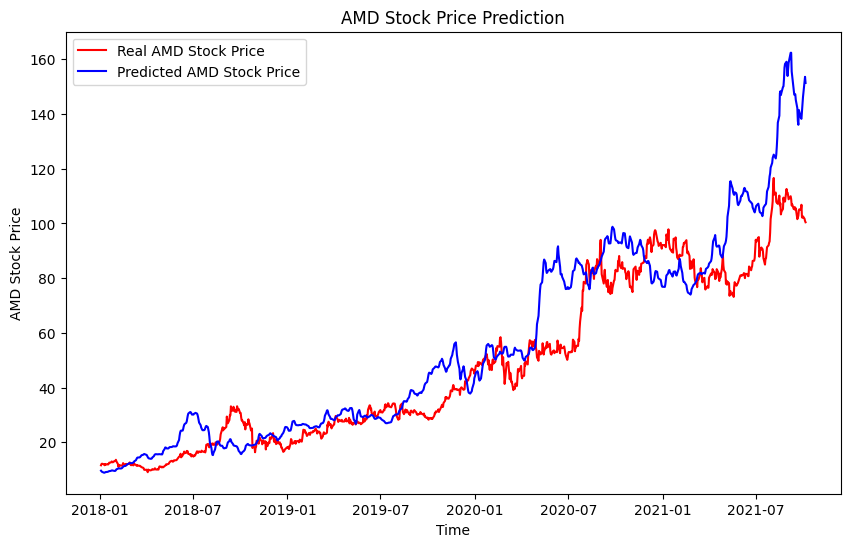

In [29]:
# Visualising the results
plt.figure(figsize=(10,6))
plt.plot(df.index.values[end_index:len(df)-60], dataset_test[0:len(dataset_test)-60].values, color = "red", label = f'Real {stock_name} Stock Price')
plt.plot(df.index.values[end_index:len(df)-60], predicted_stock_price, color = "blue", label = f'Predicted {stock_name} Stock Price')
#plt.xticks(np.arange(0,459,100))
plt.title(f'{stock_name} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{stock_name} Stock Price')
plt.legend()
plt.show()

In [30]:
save_model(model=model, dir="./model/")

In [31]:
### Sentiment Analysis

In [33]:
test_arr = []
for i in range(30):
    tmp = []
    for k in range(60):
        tmp.append(60)
    test_arr.append(tmp)

test_arr = np.reshape(test_arr,(30, 60, 1))
test_arr.shape

(30, 60, 1)

In [34]:
model.predict(test_arr)

1/1 [==============================] - 1s 1s/step


array([[2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362],
       [2.6933362]], dtype=float32)

In [36]:
save_model(model=model, dir="./model")